## Import Libary

In [1]:
import numpy as np
import pandas as pd
from numba import njit, prange, jit
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib
matplotlib.rc('figure', figsize=(10, 5))

## Read Data

In [2]:
df_data = pd.read_csv('../data/CC GENERAL.csv')
df_data = df_data.drop('CUST_ID', axis=1)
df_data_np = df_data.to_numpy()

In [3]:
def highlight_minimum_time(s):
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]

## Preprocessing

### Standard CPU

In [4]:
@njit(parallel=False)
def standard(df):
    n = df.shape[1]
    res = np.empty_like(df, dtype=np.float64)

    for i in range(n):
        data_i = df[:, i]
        res[:, i] = (data_i - np.mean(data_i)) / np.std(data_i)

    return res

### Standard CPU Parallel

In [5]:
@jit(nopython=True, parallel=True)
def standard_parallel(df):
    n = df.shape[1]
    res = np.empty_like(df, dtype=np.float64)

    for i in prange(n):
        data_i = df[:, i]
        res[:, i] = (data_i - np.mean(data_i)) / np.std(data_i)

    return res

### Expected result using Sklearn

In [6]:
expected = StandardScaler().fit_transform(df_data_np)

### Output result running by CPU

In [7]:
output = standard(df_data_np)

### Comparasion diff

In [8]:
output - expected

array([[-1.66533454e-15, -4.17166302e-14, -1.08246745e-14, ...,
                    nan, -1.66533454e-15, -6.66133815e-16],
       [-1.33226763e-15, -2.29816166e-14, -1.18238752e-14, ...,
                    nan, -4.63518113e-15, -6.66133815e-16],
       [-1.44328993e-15, -4.21884749e-15, -3.89965837e-15, ...,
                    nan, -1.66533454e-15, -6.66133815e-16],
       ...,
       [-1.77635684e-15, -3.86080057e-14, -1.03250741e-14, ...,
                    nan, -4.99600361e-15,  7.99360578e-15],
       [-1.66533454e-15, -3.86080057e-14, -1.18238752e-14, ...,
                    nan, -4.99600361e-15,  7.99360578e-15],
       [-1.66533454e-15, -7.30526750e-14, -6.17561557e-16, ...,
                    nan, -1.66533454e-15,  7.99360578e-15]])

### Output result running by CPU Parallel

In [9]:
output_parallel = standard_parallel(df_data_np)

### Comparasion diff

In [10]:
output_parallel - expected

array([[-1.66533454e-15, -4.17166302e-14, -1.08246745e-14, ...,
                    nan, -1.66533454e-15, -6.66133815e-16],
       [-1.33226763e-15, -2.29816166e-14, -1.18238752e-14, ...,
                    nan, -4.63518113e-15, -6.66133815e-16],
       [-1.44328993e-15, -4.21884749e-15, -3.89965837e-15, ...,
                    nan, -1.66533454e-15, -6.66133815e-16],
       ...,
       [-1.77635684e-15, -3.86080057e-14, -1.03250741e-14, ...,
                    nan, -4.99600361e-15,  7.99360578e-15],
       [-1.66533454e-15, -3.86080057e-14, -1.18238752e-14, ...,
                    nan, -4.99600361e-15,  7.99360578e-15],
       [-1.66533454e-15, -7.30526750e-14, -6.17561557e-16, ...,
                    nan, -1.66533454e-15,  7.99360578e-15]])

## Measure running time with different strategies

### Measure time with running with increasing number of columns

In [11]:
res = []
multiples = range(1, 30, 4)

for idx, i in enumerate(multiples):
    data = np.tile(df_data_np, i)
    
    o_1 = %timeit -o -q StandardScaler().fit_transform(data)
    o_2 = %timeit -o -q standard(data)
    o_3 = %timeit -o -q standard_parallel(data)
    
    res.append((data.shape[1], o_1.best, o_2.best, o_3.best))
    print('{0} of {1} complete {2}'.format(idx + 1, len(multiples), data.shape))

1 of 8 complete (8950, 17)
2 of 8 complete (8950, 85)
3 of 8 complete (8950, 153)
4 of 8 complete (8950, 221)
5 of 8 complete (8950, 289)
6 of 8 complete (8950, 357)
7 of 8 complete (8950, 425)
8 of 8 complete (8950, 493)


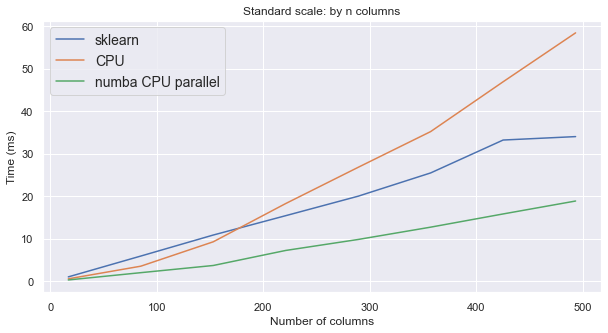

In [12]:
df_viz = pd.DataFrame(res, columns = ['num_cols', 'sklearn', 'CPU', 'numba CPU parallel'])

df_viz = df_viz.set_index('num_cols')
df_viz = df_viz.apply(lambda x: 1000 * x)

ax = df_viz.plot()
ax.set_title('Standard scale: by n columns')
ax.set_xlabel('Number of columns')
ax.set_ylabel('Time (ms)')
plt.legend(prop={'size': 14})

### Table measuring strategies check time

In [13]:
df_viz.style.apply(highlight_minimum_time, axis=1)

,sklearn,CPU,numba CPU parallel
num_cols,,,
17,0.972357,0.515274,0.251020
85,5.874334,3.489000,1.963625
153,10.823323,9.230794,3.654038
221,15.380747,18.237491,7.194427
289,19.967717,26.766150,9.779930
357,25.443217,35.175671,12.677795
425,33.186029,46.899587,15.786970
493,33.994150,58.415879,18.830637


### Measure time with running with increasing number of row

In [14]:
res = []

for idx, i in enumerate(multiples):
    data = np.tile(df_data_np.T, i).T
    o_1 = %timeit -o -q StandardScaler().fit_transform(data)
    o_2 = %timeit -o -q standard(data)
    o_3 = %timeit -o -q standard_parallel(data)
    
    res.append((data.shape[0], o_1.best, o_2.best, o_3.best))
    print('{0} of {1} complete {2}'.format(idx + 1, len(multiples), data.shape))

1 of 8 complete (8950, 17)
2 of 8 complete (44750, 17)
3 of 8 complete (80550, 17)
4 of 8 complete (116350, 17)
5 of 8 complete (152150, 17)
6 of 8 complete (187950, 17)
7 of 8 complete (223750, 17)
8 of 8 complete (259550, 17)


In [15]:
df_viz = pd.DataFrame(res, columns = ['num_rows', 'sklearn', 'numba CPU', 'numba CPU parallel'])
df_viz = df_viz.set_index('num_rows')
df_viz = df_viz.apply(lambda x: 1000 * x)

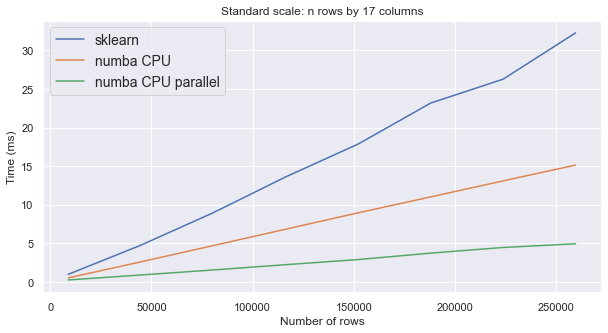

In [16]:
ax = df_viz.plot()
ax.set_title('Standard scale: n rows by 17 columns')
ax.set_xlabel('Number of rows')
ax.set_ylabel('Time (ms)')
plt.legend(prop={'size': 14})

### Table measuring strategies check time

In [17]:
df_viz.style.apply(highlight_minimum_time, axis=1)

,sklearn,numba CPU,numba CPU parallel
num_rows,,,
8950,0.982479,0.515121,0.249854
44750,4.752008,2.593286,0.893738
80550,8.964196,4.702574,1.544029
116350,13.610843,6.831162,2.227793
152150,17.865559,8.952275,2.893306
187950,23.177604,11.015213,3.727481
223750,26.275896,13.093938,4.459181
259550,32.280579,15.143415,4.940158
